In [2]:
!pip install pandas pillow

In [3]:
!pip install pandas
!pip install opencv-python

In [4]:
!pip install tensorflow==2.12.0
!pip install keras

In [5]:
!pip install -q datasets

In [6]:
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import os
from tensorflow import keras
import glob as gb
import pandas as pd
from tensorflow.keras.preprocessing import image_dataset_from_directory
# Import RandomFlip and RandomRotation from the preprocessing module
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPool2D, LeakyReLU

In [7]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Set image size for ResNet-50 (224x224)
IMG_SIZE = (224, 224)  # ResNet-50 default resolution
directory = "/kaggle/input/pepper-bell-leaf-diseases/Pepper__bell Leaf Diseases Dataset From Bangladesh"
BATCH_SIZE = 128

# Load training dataset
train_dataset = image_dataset_from_directory(
    directory,
    shuffle=True,
    labels='inferred',
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,  # Updated for ResNet-50
    validation_split=0.1,
    subset='training',
    color_mode='rgb',
    seed=42
)

# Load validation dataset
validation_dataset = image_dataset_from_directory(
    directory,
    shuffle=True,
    labels='inferred',
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,  # Updated for ResNet-50
    validation_split=0.1,
    subset='validation',
    color_mode='rgb',
    seed=42
)


Found 2475 files belonging to 2 classes.
Using 2228 files for training.
Found 2475 files belonging to 2 classes.
Using 247 files for validation.


In [8]:
class_names = train_dataset.class_names
class_names

['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy']

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


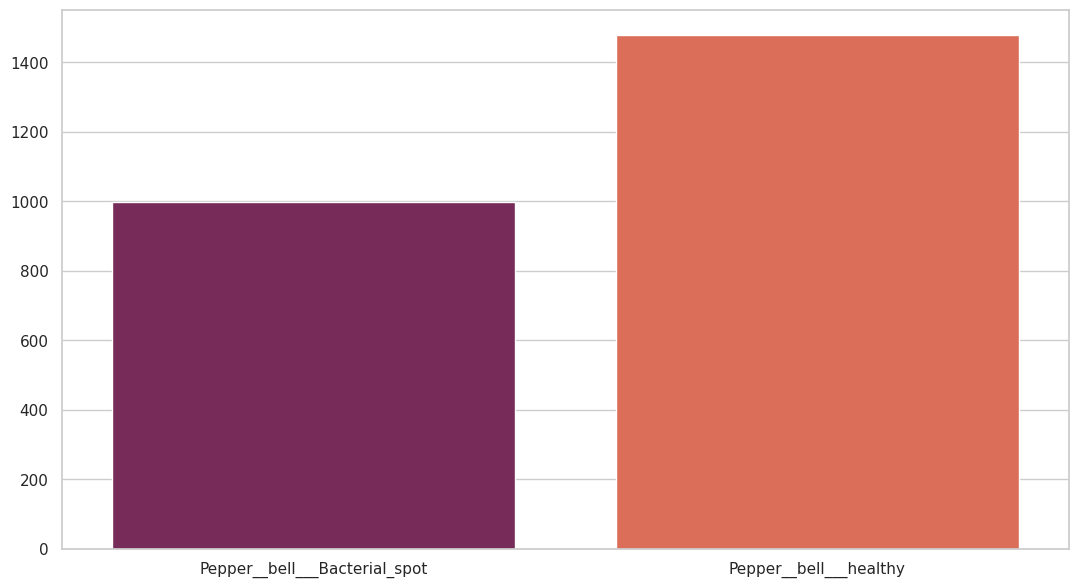

In [9]:
import os
import glob as gb
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")

# Initialize list for storing data imbalance info
Data_imbalance = []

# Loop through each class folder and count the number of images
for folder in os.listdir(directory):
    files = gb.glob(pathname=str(directory + "/" + folder + "/*.*"))
    Data_imbalance.append(len(files))

# Plot data imbalance
plt.figure(figsize=(13, 7))
sns.barplot(
    x=['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy'], 
    y=Data_imbalance, 
    palette="rocket"
)
plt.show()


In [10]:

total = 0
for i in range(0,len(Data_imbalance)) :
    total +=Data_imbalance[i]

weight_for_0 = (1 / Data_imbalance[0]) * (total / 4.0)
weight_for_1 = (1 / Data_imbalance[1]) * (total / 4.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.62
Weight for class 1: 0.42


In [11]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal"),
  tf.keras.layers.RandomRotation(0.2),
  tf.keras.layers.RandomZoom(0.2),
  tf.keras.layers.RandomHeight(0.2),
  tf.keras.layers.RandomWidth(0.2),
])

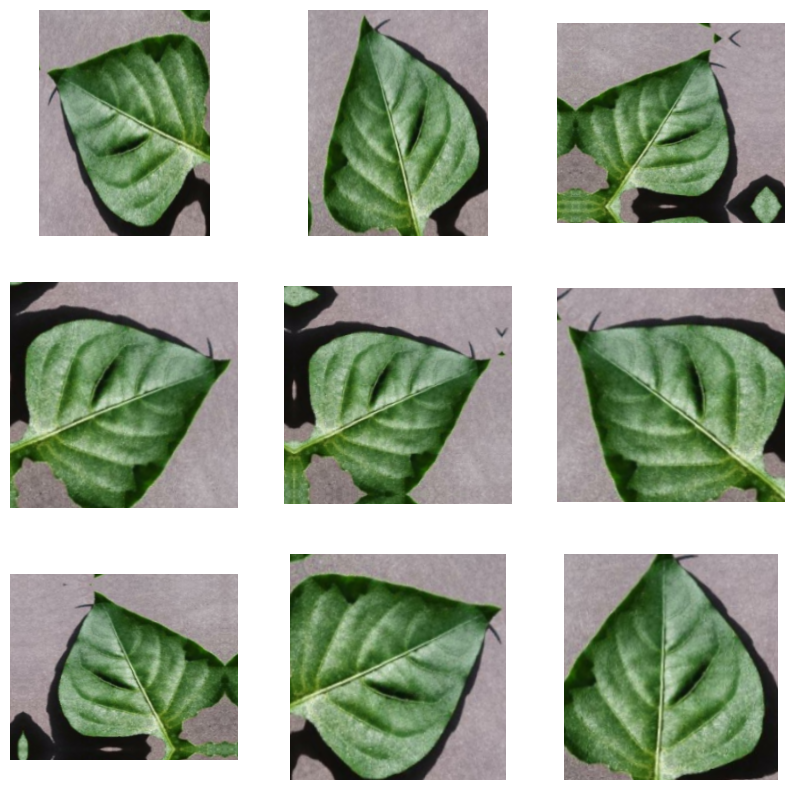

In [12]:
for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

**Pepper__bell___Bacterial_spot**

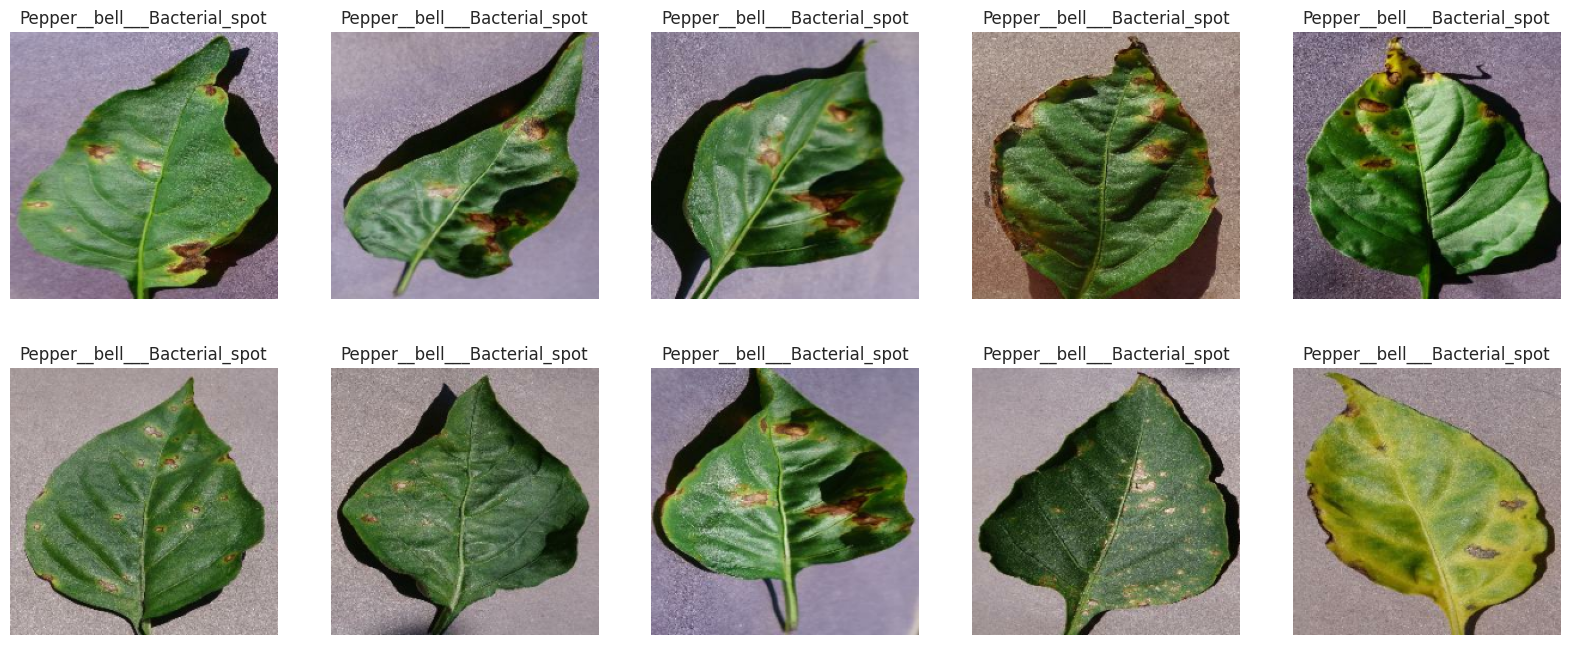

In [13]:
plt.figure(figsize=(20,8))
Pepper__bell___Bacterial_spot = []
for images , labels in train_dataset.take(1):
    for i in range(100):
        if class_names[labels[i]] == "Pepper__bell___Bacterial_spot":
            Pepper__bell___Bacterial_spot.append(images[i].numpy().astype("uint8"))

for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(Pepper__bell___Bacterial_spot[i])
    plt.axis("off")
    plt.title("Pepper__bell___Bacterial_spot")

In [14]:
import tensorflow as tf

# Enable automatic prefetching for better performance
AUTOTUNE = tf.data.AUTOTUNE  # Updated to tf.data.AUTOTUNE (latest TensorFlow versions)

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)  # Apply to validation dataset too


**MODELING**

In [15]:
import tensorflow as tf

# Define input shape for ResNet-50 (224x224, 3 channels)
IMG_SHAPE = IMG_SIZE + (3,)

# Load ResNet-50 model (pre-trained on ImageNet)
base_model = tf.keras.applications.ResNet50(
    input_shape=IMG_SHAPE,
    include_top=False,  # Exclude fully connected layer for transfer learning
    weights='imagenet'  # Use pre-trained weights
)


94765736/94765736 [==============================] - 0s 0us/step


In [16]:
# Check the type of the base model
type(base_model)

# Set the correct preprocessing function for ResNet50
preprocess_input = tf.keras.applications.resnet50.preprocess_input


In [17]:
# Count the number of layers in ResNet-50
nb_layers = len(base_model.layers)
print("Number of Layers =", nb_layers)

# Print the names of the last two layers
print("Pre-last layer name:", base_model.layers[nb_layers - 2].name)  
print("Last layer name:", base_model.layers[nb_layers - 1].name)


Number of Layers = 175
Pre-last layer name: conv5_block3_add
Last layer name: conv5_block3_out


In [18]:
# Iterate over the first batch (32 images) in the training dataset
image_batch, label_batch = next(iter(train_dataset))  # 32 image arrays

# Extract feature maps using ResNet-50
feature_batch = base_model(image_batch)  # Run images through the base model

# Print the shape of extracted features
print("Feature batch shape:", feature_batch.shape)  


Feature batch shape: (128, 7, 7, 2048)


**ResNet 50**

In [19]:
import tensorflow as tf

def plant_leaf_model(image_shape=IMG_SIZE):
    ''' Define a tf.keras model for multi-class classification using ResNet-50 '''
    image_shape = image_shape + (3,)

    # Load pre-trained ResNet-50 model (without the classification head)
    resnet_model = tf.keras.applications.ResNet50(
        input_shape=image_shape, 
        include_top=False, 
        weights='imagenet'
    )

    # Freeze the initial layers to retain pre-trained features
    resnet_model.trainable = True
    for layer in resnet_model.layers[:143]:  # Fine-tuning from layer 143 onwards
        layer.trainable = False

    # Define the input layer
    inputs = tf.keras.Input(shape=image_shape)
    
    # Data augmentation (if defined)
    x = data_augmentation(inputs)
    
    # Preprocess input for ResNet-50
    x = tf.keras.applications.resnet50.preprocess_input(x)
    
    # Pass through ResNet-50 base model
    x = resnet_model(x, training=False)

    # Global Average Pooling layer
    x = tf.keras.layers.GlobalAveragePooling2D()(x)

    # Dropout to prevent overfitting
    x = tf.keras.layers.Dropout(0.2)(x)

    # Fully connected layer for classification
    prediction_layer = tf.keras.layers.Dense(4, activation="softmax")
    outputs = prediction_layer(x)

    # Define the final model
    model = tf.keras.Model(inputs, outputs)
    
    # Print model summary
    model.summary()
    
    return model


In [20]:
Plant_Leaf_Model = plant_leaf_model(IMG_SIZE)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, None, None, 3)     0         
                                                                 
 tf.__operators__.getitem (S  (None, None, None, 3)    0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, None, None, 3)    0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                      

In [21]:
# Lower learning rate for fine-tuning to avoid destroying pre-trained weights
base_learning_rate = 0.0001  # Reduced from 0.1 to 0.0001 for stability

Plant_Leaf_Model.compile(
    optimizer=tf.keras.optimizers.Nadam(learning_rate=base_learning_rate),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)


In [22]:
history = Plant_Leaf_Model.fit(
    train_dataset,  # Training dataset
    epochs=10,  # Number of epochs
    verbose=2,  # Display progress in a more readable format
    class_weight=class_weight,  # Handle class imbalance (if defined)
    validation_data=validation_dataset,  # Validation dataset
    use_multiprocessing=True,  # Speed up training with multiple processes
    workers=4  # You can increase workers for better data loading performance
)


Epoch 1/10
18/18 - 361s - loss: 0.2249 - accuracy: 0.8285 - val_loss: 0.0521 - val_accuracy: 0.9798 - 361s/epoch - 20s/step
Epoch 2/10
18/18 - 317s - loss: 0.0222 - accuracy: 0.9910 - val_loss: 0.0300 - val_accuracy: 0.9919 - 317s/epoch - 18s/step
Epoch 3/10
18/18 - 317s - loss: 0.0112 - accuracy: 0.9924 - val_loss: 0.0993 - val_accuracy: 0.9636 - 317s/epoch - 18s/step
Epoch 4/10
18/18 - 322s - loss: 0.0063 - accuracy: 0.9951 - val_loss: 0.0013 - val_accuracy: 1.0000 - 322s/epoch - 18s/step
Epoch 5/10
18/18 - 309s - loss: 0.0021 - accuracy: 0.9982 - val_loss: 1.0685e-04 - val_accuracy: 1.0000 - 309s/epoch - 17s/step
Epoch 6/10
18/18 - 309s - loss: 0.0061 - accuracy: 0.9960 - val_loss: 0.0030 - val_accuracy: 1.0000 - 309s/epoch - 17s/step
Epoch 7/10
18/18 - 312s - loss: 9.9949e-04 - accuracy: 1.0000 - val_loss: 0.0014 - val_accuracy: 1.0000 - 312s/epoch - 17s/step
Epoch 8/10
18/18 - 300s - loss: 0.0065 - accuracy: 0.9924 - val_loss: 0.0059 - val_accuracy: 1.0000 - 300s/epoch - 17s/step


In [23]:
# Evaluate the model on the validation dataset
validation_loss, validation_accuracy = Plant_Leaf_Model.evaluate(validation_dataset, verbose=1)

# Print the evaluation results
print(f"Validation Loss: {validation_loss}")
print(f"Validation Accuracy: {validation_accuracy}")


2/2 [==============================] - 21s 10s/step - loss: 0.0030 - accuracy: 1.0000
Validation Loss: 0.002995760878548026
Validation Accuracy: 1.0


1/1 [==============================] - 0s 105ms/step


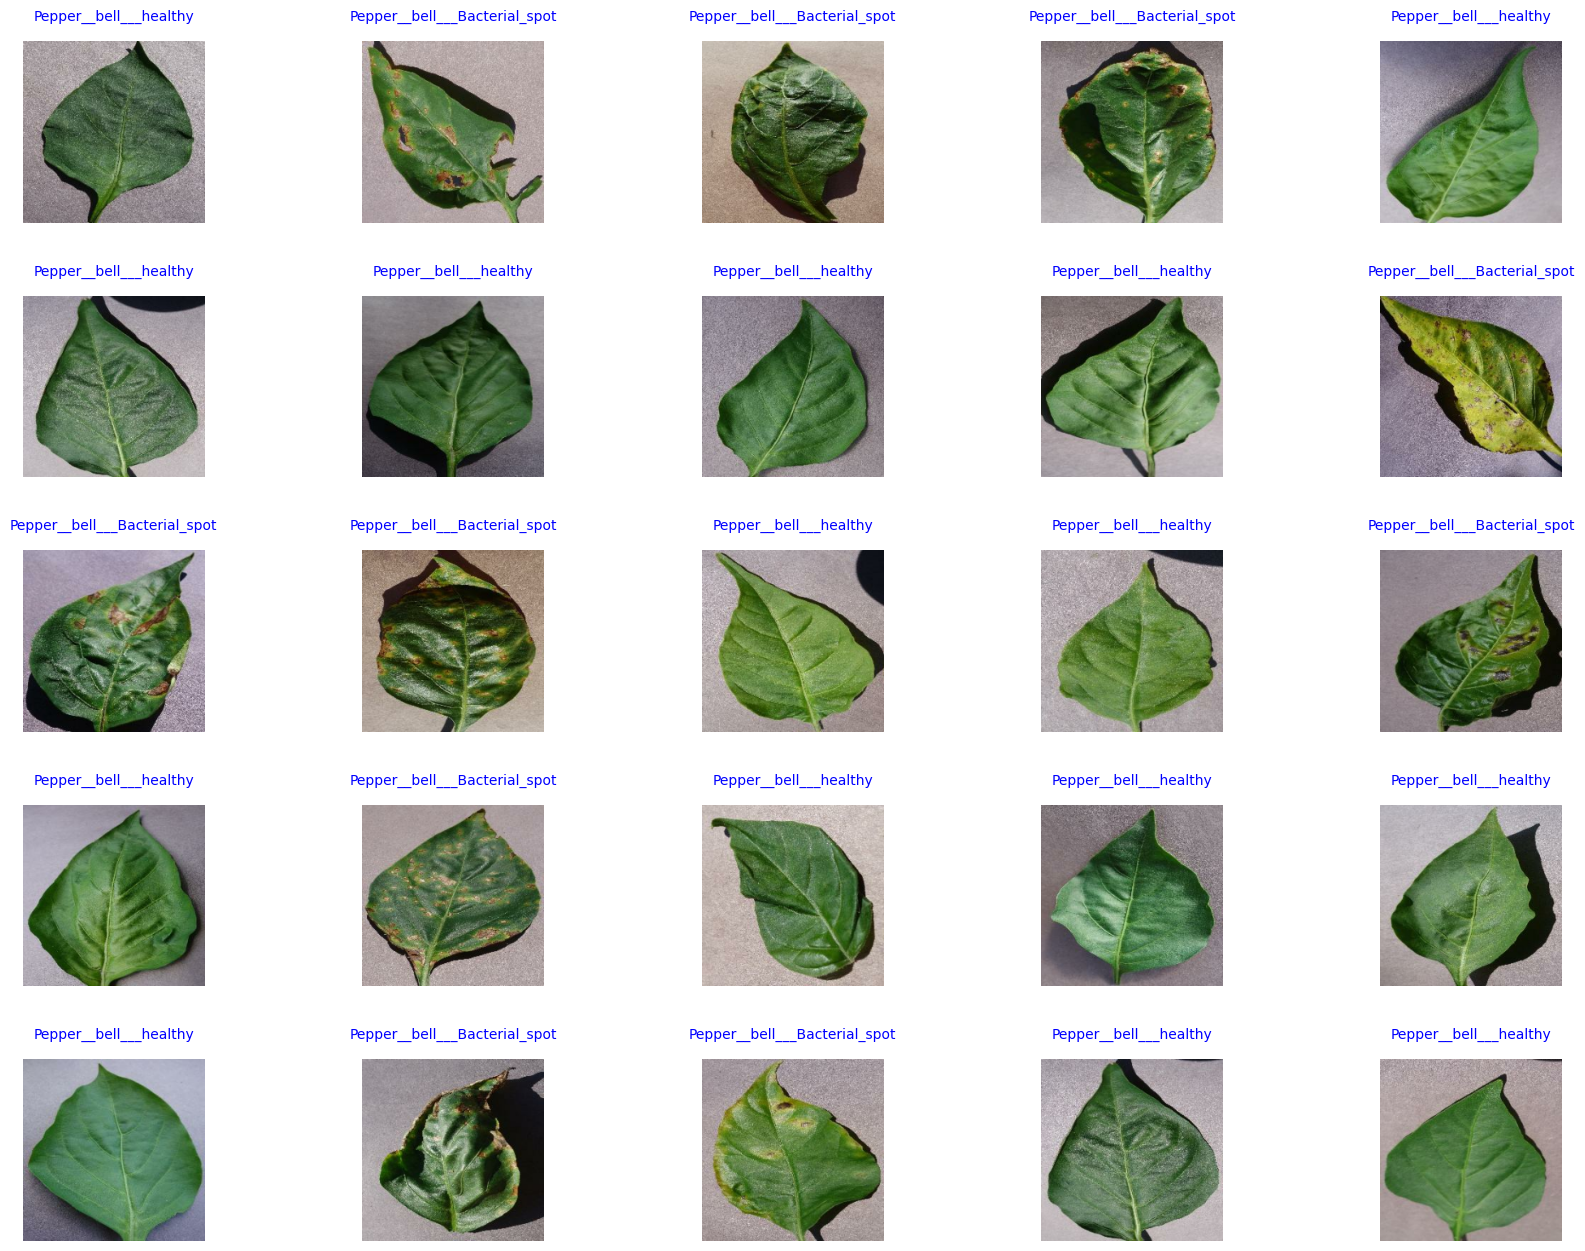

In [24]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

# Visualize predictions for a batch of 25 images
plt.figure(figsize=(20, 15))

for images, labels in train_dataset.take(1):  # Take the first batch from train_dataset
    for i in range(25):  # Loop over the first 25 images in the batch
        plt.subplot(5, 5, i + 1)  # Create a 5x5 grid of subplots
        plt.imshow(images[i].numpy().astype("uint8"))  # Display image
        plt.axis("off")  # Hide axes

        # Predict class for the current image
        im2 = images[i].numpy().astype("uint8")
        img2 = tf.expand_dims(im2, 0)  # Expand dimensions for prediction
        predict = Plant_Leaf_Model.predict(img2)
        predicted = class_names[np.argmax(predict)]  # Get predicted class
        actual = class_names[labels[i].numpy().astype("uint8")]  # Get actual class

        # Display title: blue if correct, red if incorrect
        if actual == predicted:
            plt.title(predicted, fontsize=10, color='blue', pad=15)
        else:
            plt.title(actual, fontsize=10, color='red', pad=15)

    plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)
    plt.show()


**Plotting Accuracy**

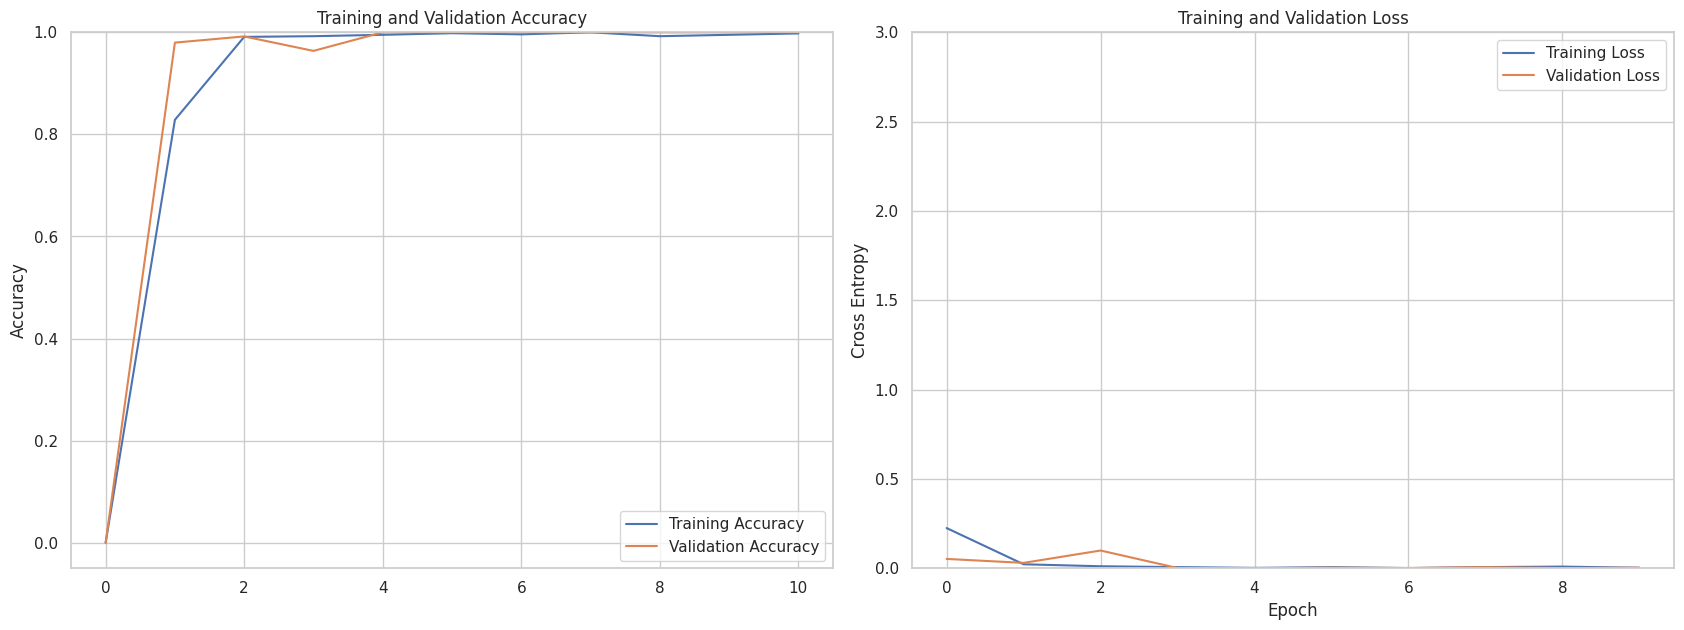

In [25]:
import matplotlib.pyplot as plt

# Extract accuracy and loss values from training history
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Plotting the graphs
plt.figure(figsize=(17, 12))

# Subplot for Accuracy
plt.subplot(2, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()), 1])  # Y-axis from min value to 1
plt.title('Training and Validation Accuracy')

# Subplot for Loss
plt.subplot(2, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0, 3.0])  # Y-axis range for loss
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')

# Show the plots
plt.tight_layout()  # Adjusts subplots to fit better
plt.show()


4/4 [==============================] - 9s 2s/step


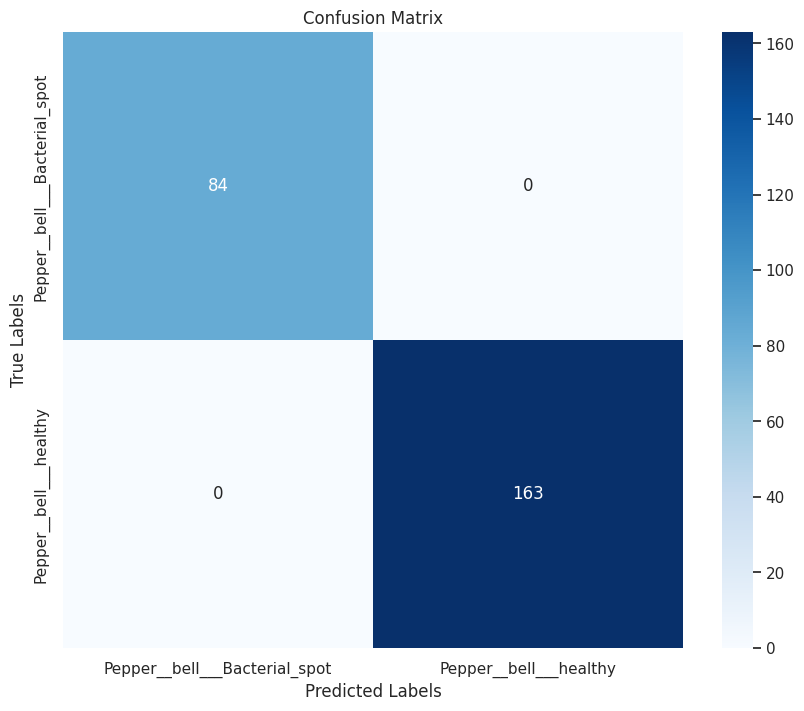

Confusion Matrix:
[[ 84   0]
 [  0 163]]
Classification Report:
                               precision    recall  f1-score   support

Pepper__bell___Bacterial_spot       1.00      1.00      1.00        84
       Pepper__bell___healthy       1.00      1.00      1.00       163

                     accuracy                           1.00       247
                    macro avg       1.00      1.00      1.00       247
                 weighted avg       1.00      1.00      1.00       247



In [26]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Get true labels and predicted labels
true_labels = []
predicted_labels = []

# Loop through the validation dataset to collect true and predicted labels
for images, labels in validation_dataset:
    predictions = Plant_Leaf_Model.predict(images)
    predicted_classes = np.argmax(predictions, axis=1)  # Get the index of the predicted class
    true_labels.extend(labels.numpy())  # Convert tensor to numpy and add to list
    predicted_labels.extend(predicted_classes)  # Add predicted classes to list

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Print confusion matrix separately
print("Confusion Matrix:")
print(conf_matrix)

# Generate and print classification report
report = classification_report(true_labels, predicted_labels, target_names=class_names)
print("Classification Report:")
print(report)


In [27]:
# Print classification report separately
print("Classification Report:")
report = classification_report(true_labels, predicted_labels, target_names=class_names)
print(report)


Classification Report:
                               precision    recall  f1-score   support

Pepper__bell___Bacterial_spot       1.00      1.00      1.00        84
       Pepper__bell___healthy       1.00      1.00      1.00       163

                     accuracy                           1.00       247
                    macro avg       1.00      1.00      1.00       247
                 weighted avg       1.00      1.00      1.00       247

